## Objective:
- user inputs on dateTime range, Location, Layers
- Generate XML files via user input time range, Layer(Satellite)
    - The purpose of this files creation is to pass as PARAMETERS on XML requests on GIBS
- Retrieve raster file from XML file by Location (coordinates passed)
- GENERATE daily, monthly, yearly data
- CREATE animation on desired range

#### NOTE: may require to download some of the libraries used below

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## GDAL processing the XML file
from osgeo import gdal
from time import sleep

## GEOPY package to locate the region
from geopy.geocoders import Nominatim
import geopy

## font styles
from PIL import Image, ImageFont
from PIL import ImageDraw
import imageio

import os
import gc

## animation
import glob
from PIL import Image, ImageSequence

## ENTER the time range:
- Generate monthly Data range

In [2]:
print('Time Range: Year - Month - Day')
year= input("Enter year: ")
month= input("Enter month: ")

# Create a time range: Year/ month / day
new_time= year+'-'+month #+'-'+ day
print(new_time)
print('*************************************\n')

Time Range: Year - Month - Day
Enter year: 2021
Enter month: 07
2021-07
*************************************



## Retrieve information from desired location; coords passed by user

In [3]:
## Get the BBX information
# Enter the location
location= input("Enter the location: ")
geo_loc= Nominatim(user_agent="locate", timeout=8)

info= geo_loc.geocode(str(location)).raw

## get the Bounding box information
loc_bbx= info["boundingbox"]
bbx_list= [float(i) for i in loc_bbx]

print('\n************************************\n')
print("Bbox information of :\n"+f'{location}')
bbx_list

Enter the location: California

************************************

Bbox information of :
California


[32.5295236, 42.009499, -124.482003, -114.1307816]

## LAYERS input
- Satellite layers that will be used to pass along the XML querry to get the layer
- Get more layers available by GIBS through this code:


In [4]:
### several other LAYERS
# layer_name="Agricultural_Lands_Croplands_2000"

## OCO
#layer_name="OCO-3_Carbon_Dioxide_Total_Column_Average"
#layer_name="OCO-2_Carbon_Dioxide_Total_Column_Average"
#layer_name="MERRA2_Convective_Rainwater_Source_700hPa_Monthly"

#### MODIS 
layer_name= "MODIS_Terra_Land_Surface_Temp_Day"
#layer_name= "MODIS_Terra_Cloud_Water_Path"
# layer_name="MODIS_Aqua_Land_Surface_Temp_Day"

#layer_name="MODIS_Aqua_L2_Sea_Surface_Temp_Day"

## Write a Bounding Box information
- Using user input information on Geo_location request inside a TXT file locally
- This bbx information with coordinates will be use with GDAL to retrieve TIFF files from desired location

In [5]:
### current bbx information from the USER's desired location
a_dict= {"a": bbx_list[0],
         "b": bbx_list[1],
         "c": bbx_list[2],
         "d": bbx_list[3]}

a_dict

{'a': 32.5295236, 'b': 42.009499, 'c': -124.482003, 'd': -114.1307816}

## Alternate Approach:
### GLOBAL SCALE:
- if user wants to retrieve TIFF file from GLOBAL range, uncomment the below sections and used the global coverage, this will overwrite any existing information on Bounding box
- lon_min= -180, lon_max= 180, lat_min= -90, lat_max= 90


In [6]:
# a_dict= {
#     "a": -90,
#     "b": 90,
#     "c": -180,
#     "d": 180
# }

# a_dict

### Creating a TEXT file with location(bounding box) information on file locally

In [7]:
with open("bbx_list.txt", 'w') as f: 
    for key, value in a_dict.items(): 
        f.write('%s=%s\n' % (key, value))
f.close()

In [8]:
%%bash
cat bbx_list.txt

a=32.5295236
b=42.009499
c=-124.482003
d=-114.1307816


## Creating another TEXT file to store location information passed by USER inputs
- Write the location name and Layer name in text file

### NOTE: The purpose of this files creation is to pass as PARAMETERS on XML requests on GIBS

In [9]:
## Reformating the filenames for location STRING, replace the Empty space to make a DIR. file
location= location.replace(" ","_")

text_file = open("location.txt", "w")
n = text_file.write(str(location))
text_file.close()

layer_dir = open("layer.txt", "w")
n = layer_dir.write(str(layer_name))
layer_dir.close()

## Reading the text file for BBX information from previously created TXT file and use as parameter on GDAL
- bbx list stored in parameters:
    - a, b, c, d

### Example:

In [10]:
%%bash

source "bbx_list.txt"
echo $b

42.009499


## PLOT the raster images
- based on RASTER count bands to display the `tiff` images

In [11]:
def read_tiff(img_):
    data= gdal.Open(str(img_))

    if data.RasterCount == 3:
        band_1= data.GetRasterBand(1)
        band_2= data.GetRasterBand(2)
        band_3= data.GetRasterBand(3)

        ## Read the bands as array
        b1= band_1.ReadAsArray()
        b2= band_2.ReadAsArray()
        b3= band_3.ReadAsArray()

        img= np.dstack((b1, b2, b3))

    elif data.RasterCount == 4:
        band_1_a= data.GetRasterBand(1)
        band_2_a= data.GetRasterBand(2)
        band_3_a= data.GetRasterBand(3)
        band_4_a= data.GetRasterBand(4)

        ## Read the bands as array
        b1= band_1_a.ReadAsArray()
        b2= band_2_a.ReadAsArray()
        b3= band_3_a.ReadAsArray()
        b4= band_4_a.ReadAsArray()

        img= np.dstack((b1, b2, b3, b4))
        
    ## Display the image
    f= plt.figure(figsize=(8, 6), dpi=200)
    plt.imshow(img)


# Create a XML file and Retrieve `tiff` from GIBS imagery
1. First, we will generate XML files with <b>USERS passed inputs</b> as parameters and used with `GDAL` to retrieve `TIFF` files
2. Filtering the fienames; Replace any spaces with underscores
- EXAMPLE:
    - `<TiledGroupName>` `layer` tileset  `<TiledGroupName>`

## Create directory to store XML files
- These generated XML files will be used along with USER passed parameters to retrieve GeoTIFF files from GIBS
- Each XML files will be saved inside the LAYER name-> location

In [12]:
%%bash
[ -d xml_files ] || mkdir xml_files

## MODIS; LST

In [13]:
%%bash
[ -d xml_files/modis ] || mkdir xml_files/modis 

In [14]:
def create_xml_file(layer_name, dateTime, layer, location):
    
    location= location.replace(" ","_")
    # make the dir. under layer name BY location
    if not os.path.exists("xml_files/" + str(layer_name) +"/"+str(location)):
        os.makedirs("xml_files/" + str(layer_name) +"/"+str(location))
    else:
        pass
    
    ## Rename the files
    layer_= layer.replace('_', ' ')
    
    # Retrieve files for set time, daily/monthly
    new_time= dateTime

    ## Replace the time setting with New time parameters
    ## HERE, the var 'time' will be replaced with USER input value
    time= '${time}'

    xml_content = '''<GDAL_WMS>
      <Service name="TiledWMS">
        <ServerUrl>https://gibs.earthdata.nasa.gov/twms/epsg4326/best/twms.cgi?</ServerUrl>
        <TiledGroupName>{layer} tileset</TiledGroupName>
        <Change key="{time}">{new_time}</Change>
        <DataWindow>
            <UpperLeftX>33.659541</UpperLeftX>
            <UpperLeftY>34.337306</UpperLeftY>
            <LowerRightX>-118.6681779</LowerRightX>
            <LowerRightY>-118.1552947</LowerRightY>
        </DataWindow>
      </Service>
    </GDAL_WMS>'''.format(new_time= new_time, time= time, layer= layer_)

    with open('xml_files/' + layer_name + '/'+str(location)+'/'+ str(layer_name)+'_'+str(new_time) +'.xml', 'w') as xml_file:
        xml_file.write(xml_content)

## Function to generate MONTHLY files: total range: 30 days
- Now we can generate XML files for desired days, months.
- In this example, we will use the above function to generate files for a month. This will generate 30 XML files inside
    the directory `'xml_files'/{layer_name}`


In [15]:
'''
    1. pass the LAYER name to generate XML files
    2. Pass the DAILY `dateTime` data with Year/month Variable
        EG: current format: 
            * 2005-05 -> 2005-05-25
'''

## genrate 30 day range of files
for j in range(1, 31):
    ## creating DOUBLE digit for days
    if len(str(j)) == 1:
#         print(str(year) + "-"+str(month) +"-"+ '0'+str(j))

        new_date= str(year)+"-"+str(month)+"-"+'0'+str(j)
        create_xml_file(layer_name, new_date, layer_name, location)
    else:
        new_date= str(year)+"-"+str(month)+"-"+str(j)
        create_xml_file(layer_name, new_date, layer_name, location)

##  Using the store location bounding box infromation with GDAL
- GDAL bounding box: cords from USER inputs on geoLocation
- using geopy to retrieve geolocation information

California: [32.5295236, 42.009499, -124.482003, -114.1307816]

- EG:
    - gdal_translate -of GTiff -outsize 1800 1200 -projwin `upper_right` `lower_left` `lower_right` `upper_left` `XML file` `TIFF file`
    
    - gdal_translate -of GTiff -outsize 1800 1200 -projwin -124.48200 42.009 -114.1307 32.5295236 GIBS_Aqua_MODIS_true.xml GreatPlain.tiff
    - gdal_translate -of GTiff -outsize 1800 1200 -projwin `$c` `$b` `$d` `$a` `XML file` `tiff file`

## MODIS; LST
- using the cords from the `txt` file of boundingbox list and using to retrieve MODIS,lst from desired location

## Medium Range of pixels

In [16]:
%%bash

read -r loc < location.txt
read -r layer < layer.txt

echo $loc, $layer
ls xml_files/$layer/$loc

California, MODIS_Terra_Land_Surface_Temp_Day
MODIS_Terra_Land_Surface_Temp_Day_2021-07-01.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-02.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-03.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-04.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-05.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-06.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-07.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-08.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-09.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-10.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-11.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-12.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-13.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-14.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-15.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-16.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-17.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-18.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-19.xml
MODIS_Terra_Land_Surfac

# LOCATION;
- WRITE in a single file that will be read by GDAL

In [17]:
# ## location STRING, replace the Empty space to make a DIR. file
# location= location.replace(" ","_")

# text_file = open("location.txt", "w")
# n = text_file.write(str(location))
# text_file.close()

# LAYER NAME
- createing at ext file with LAYER name

In [18]:
# layer_dir = open("layer.txt", "w")
# n = layer_dir.write(str(layer_name))
# layer_dir.close()

### Check the if the XML files have generated
- using USER's passed parameters on TIME and Location to generate XML files 

In [19]:
%%bash
read -r loc < location.txt
read -r layer < layer.txt

ls xml_files/"$layer"/"$loc"

MODIS_Terra_Land_Surface_Temp_Day_2021-07-01.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-02.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-03.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-04.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-05.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-06.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-07.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-08.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-09.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-10.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-11.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-12.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-13.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-14.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-15.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-16.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-17.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-18.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-19.xml
MODIS_Terra_Land_Surface_Temp_Day_2021-07-20.xml
MODIS_Terra_Land_Sur

## Using Bash Script to loop over the XML files generated above and GET tiff files
- Using GDAL to retrieve layers with XML requests on GIBS server
    1. first, reads the LAYER name and Location information
    2. Second, Uses the XML files generated above from the Dir. and loops over every XML files and make requests to GIBS Server and retrieves `Tiff` files using `GDAL`
    3. Parameters passed with `gdal_translate` `outsize` or alternate params is -`tr` which can be reconfigured to generate pixel sizes of Tiff files

In [20]:
%%bash

## READ the LAYER and location from the file and use as PATH to generate TIFF file and save

read -r loc < location.txt
read -r layer < layer.txt

for file in xml_files/${layer}/${loc}/*;

do 
    source "bbx_list.txt"
    gdal_translate -of GTiff -outsize 450 400 -projwin $c $b $d $a "${file}" "${file%.*}.tiff" --config GDAL_PDF_DPI 600

done  

Input file size is 40960, 20480
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 40960, 20480
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 40960, 20480
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 40960, 20480
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 40960, 20480
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 40960, 20480
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 40960, 20480
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 40960, 20480
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 40960, 20480
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 40960, 20480
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 40960, 20480
0...10...20...30...40...50...60...70..

## GLOBAL tiff images
- recomended size for `outsize`
    * `gdal_translate -of GTiff -outsize 5000 3000 -projwin $c $b $d $a "${file}" "${file%.*}.tiff" --config GDAL_PDF_DPI 600`


## EXMAPLES; using Alternate params: `-tr` Target size and Pixel size to generate tiff files

In [21]:
# %%bash

# ## READ the LAYER and location from the file and use as PATH to generate TIFF file and save

# read -r loc < location.txt
# read -r layer < layer.txt

# for file in xml_files/${layer}/${loc}/*;

# do 
#     source "bbx_list.txt"
#     gdal_translate -of GTiff -a_nodata 0 -tr 0.6 0.6 -projwin $c $b $d $a "${file}" "${file%.*}.tiff" --config GDAL_PDF_DPI 600

# done  

## Displaying single TIFF FILE:

In [22]:
tiff_files= os.listdir("xml_files/" + layer_name +'/'+location)
## join with ROOT dir.
tiff_files= [ "xml_files/" + layer_name +'/'+location +'/'+ f for f in tiff_files]

## Get TIFF files dir.
tiff_files= [ f for f in tiff_files if ".tiff" in f]
tiff_files[:2]

['xml_files/MODIS_Terra_Land_Surface_Temp_Day/California/MODIS_Terra_Land_Surface_Temp_Day_2021-07-01.tiff',
 'xml_files/MODIS_Terra_Land_Surface_Temp_Day/California/MODIS_Terra_Land_Surface_Temp_Day_2021-07-02.tiff']

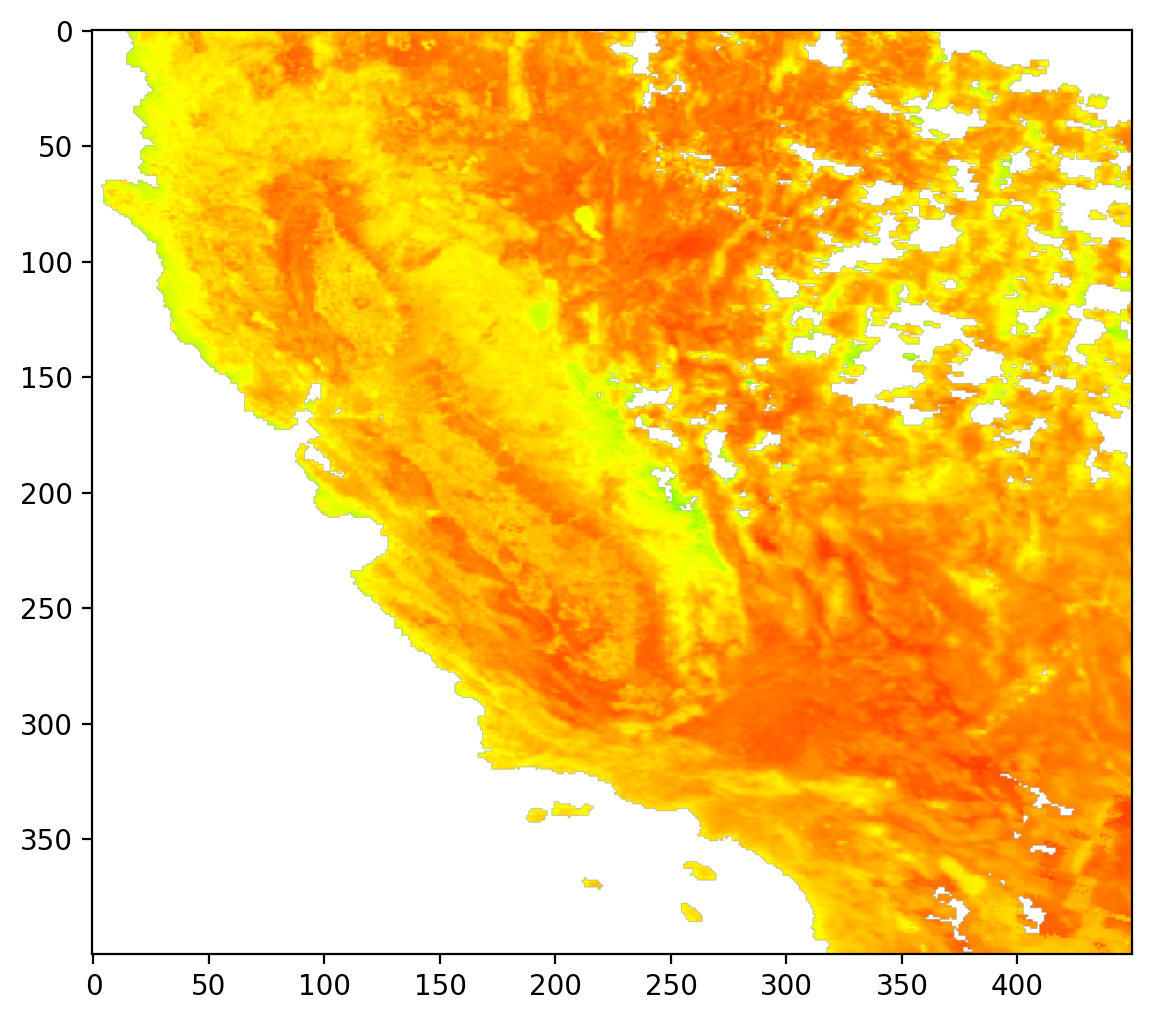

In [23]:
read_tiff(tiff_files[0])

## Using GDAL, readonly

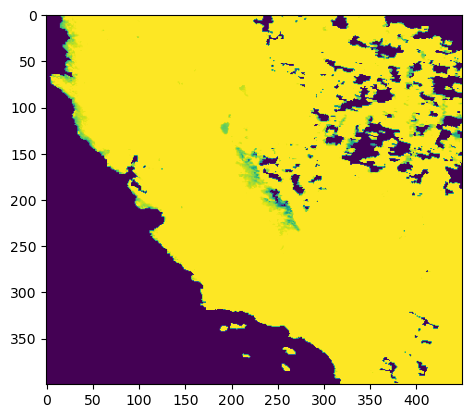

In [24]:
dataset = gdal.Open(tiff_files[0], gdal.GA_ReadOnly) 
# Note GetRasterBand() takes band no. starting from 1 not 0
band = dataset.GetRasterBand(1)
arr = band.ReadAsArray()
plt.imshow(arr)

## Make MP4 animation with the TIFF files
- Create a DIR. of the LOCATION inside the layer name

In [25]:
def make_gif(path, layer_name, year, month):
    frames= [Image.open(image) for image in glob.glob(f"{path}/*.tiff")]
    
    frame_one= frames[0]
    frame_one.save(str(layer_name)+"_"+ location +"_"+str(year)+"_"+str(month)+"_.mp4", format= "GIF", append_images= frames,
                  save_all= True, duration= 1200, loop=0)

### GIF format

In [26]:
# def make_gif(path, layer_name, year, month):
#     frames= [Image.open(image) for image in glob.glob(f"{path}/*.tiff")]
    
#     frame_one= frames[0]
#     frame_one.save(str(layer_name)+"_"+ location +"_"+str(year)+"_"+str(month)+"_.gif", format= "GIF", append_images= frames,
#                   save_all= True, duration= 1200, loop=0)

## Searches the XML files generated inside the Dir.

In [27]:
path_tif= "xml_files/"+ layer_name + "/" + location +"/"

make_gif(path_tif, layer_name, year, month)

## Example:
- GIF -> PNG file

In [28]:
# %%bash
# gdal_translate -of PNG -co "WORLDFILE=YES" TEST_example_A.tiff global_crop.png

## Further preprocessing the TIFF files
- If we want to add TEXT inside PNG/TIFF 
- Adding TEXT inside on the PNG files for animation display

In [29]:
# ## locate the dir. of files
# path_tif= os.listdir("xml_files/"+ layer_name + "/" + location +"/")
# ## adding the root dir.
# path_tif= [ "xml_files/"+ layer_name + "/" + location +"/" + f for f in path_tif]
# ## rallocate the tiff files
# path_tif= [f for f in path_tif if "tiff" in f]
# path_tif[:3]

## example

In [30]:
# img= Image.open(path_tif[2])
# font_type = ImageFont.truetype("arial.ttf", 80)

# I1= ImageDraw.Draw(img)
# I1.text((100, 150), "MODIS: Sea Surface Temp.\n" + str(date), font=font_type, fill=(255, 0, 0))
# # img.save("test.png")
# img.show()

In [31]:
!mkdir modis_png_files

In [32]:
# for j in range(0, len(path_tif)):

#     ## READ the date of the filename
#     date= str(path_tif[j])
#     date= date[ date.index("20") : date.index(".t")]
    
#     ## Open the file with PIL lib.
#     ## use the font the write the text
#     img= Image.open(path_tif[j])
#     font_type = ImageFont.truetype("arial.ttf", 90)

#     text1= ImageDraw.Draw(img)
#     text1.text((100, 150), "MODIS11; Sea Surface Temp.",
#               font=font_type, fill=(255, 0, 0))
    
#     text2= ImageDraw.Draw(img)
#     text2.text((100, 150), str(date),
#             font=font_type, fill=(255, 0, 0))

#     img.save("modis_png_files/date_strings/"+ str(date) +".png" )

In [33]:
# def make_gif_a(path, layer_name, year, month):
#     frames= [Image.open(image) for image in glob.glob(f"{path}/*.png")]
    
#     frame_one= frames[0]
#     frame_one.save(str(layer_name)+"_compressed_"+ location +"_"+str(year)+"_"+str(month)+"_.gif", format= "GIF", append_images= frames,
#                   save_all= True, duration= 1200, loop=0)

# path_to_png_files= "modis_png_files/"

# make_gif_a(path_to_png_files, layer_name, year, month)